In [16]:
from crpropa import *
from crpropa import Module
from Monopole import Monopole
import math
import numpy as np

In [17]:
def analytical_solution(p_z, r_g_0, t):
    # calculate the time stamps similar to that used in the numerical simulation
    # shift the phase so that the analytical solution
    # also starts at (0,0,0) with in the direction (p_x,p_y,p_z)
    
    #helper values
    p = np.sqrt((energy + m*c_squared)**2 - (m*c_squared)**2)/c_light
    Z = -1 * g * B / m
    uz = p * p_z / m
    up = p * (1-p_z**2)**(1/2.) / m
    A = np.sqrt(c_squared + up**2 + uz**2)

    z_ana = A * c_light / Z - c_light / Z * np.sqrt((Z * t - uz)**2 + c_squared + up**2)
    
    # for parallel motion corrected gyro radius
    r_g = r_g_0*(1-p_z**2)**0.5
    
    #Helper values
    alpha = q* eplus * c_light/g
    beta = Z / g / B / c_light * (m*c_squared + energy + g*B*A*c_light/Z)
    delta = c_squared + up**2
    x = Z*t - uz
    phi = -alpha *np.log(np.sqrt(delta+x**2)+x) - alpha*beta*(np.arctan(beta * x / (np.sqrt((delta-beta**2)*(delta+x**2)))) + np.arctan(x/np.sqrt(delta-beta**2)))/(np.sqrt(delta-beta**2))
    x0 = -uz
    phi0 = -alpha *np.log(np.sqrt(delta+x0**2)+x0) - alpha*beta*(np.arctan(beta * x0 / (np.sqrt((delta-beta**2)*(delta+x0**2)))) + np.arctan(x0/np.sqrt(delta-beta**2)))/(np.sqrt(delta-beta**2))
    phi = phi - phi0 - 3*math.pi/4
    
    # at these trajectory lengths, the numerical solutions are known
    x_ana = r_g*np.cos(phi)
    y_ana = -1*r_g*np.sin(phi)
    
    return x_ana, y_ana, z_ana / pc

In [18]:
class MyTrajectoryOutput(Module):
    def __init__(self, fname):
        Module.__init__(self)
        #self.fout = open(fname, 'w')
        #self.fout.write('%i\t%.3f\t%.3f\t%.3f\n'%(1, 0, 0, 0))
    def process(self, c):
        i = 1
        c = Monopole.MCandidate.convertToMCandidate(c)
        v = c.Mcurrent.getVelocity()
        x = v.x
        y = v.y
        z = v.z
        #print(c.current.getEnergy() / EeV)
        #self.fout.write('%i\t%.3f\t%.3f\t%.3f\n'%(i, x, y, z))
    def close(self):
        pass
        #self.fout.close()

In [19]:
import numpy as np
from crpropa import *
import math

# Gyro radius should be R_g = 10.810076 parsecs for p_z = 0 and B = 10nG and E = 100 TeV
def larmor_radius(c, field):
    p = c.current.getMomentum()
    try:
        B = field.getRegularField(c.current.getPosition())
    except:
        B = field.getField(c.current.getPosition())
        q = c.current.getCharge()
        p_perp = p.getPerpendicularTo(B)
    try:
        r =  abs(p_perp.getR() / (B.getR()*q))
    except ZeroDivisionError:
        r = 1000000
    return r / pc

In [117]:
import time as Time

# We use only a Background magnetic field in the z-direction.
# We could add more complex magentic fields to our MagneticFieldList.
B = 10*nG
direction_B = Vector3d(0, 0, 1)

const_mag_vec = direction_B * B
reg_field = UniformMagneticField(const_mag_vec)

m = 100*gigaelectronvolt/c_squared 
g = 1*Monopole.gD
q = 199
energy = 0.01 * EeV

### Running the simulation with either CK or BP
def run_simulation(module, p_z):
    # Initial condition of candidate
    p_x = (1-p_z**2)**(1/2.)/2**0.5
    p_y = p_x
    direction = Vector3d(p_x, p_y, p_z)
    position = Vector3d(0, 0, 0)

    id = 4110000 + q*10
    c = Monopole.MCandidate(id, energy, position, direction, m, g)
    print(c.Mcurrent.getDescription())

    r_g_0 = larmor_radius(c, reg_field)

    sim = ModuleList()
    if module == 'CK':
        sim.add(Monopole.MonopolePropagationCK(reg_field,1e-4,steplength, steplength))
        output = TextOutput('trajectory_CK.txt', Output.Trajectory3D)
    elif module == 'BP':
        sim.add(Monopole.MonopolePropagationBP(reg_field, steplength))
        output = TextOutput('trajectory_BP.txt', Output.Trajectory3D)
    else:
        print('no module found. Use either BP or CK.')
        return

    #debug
    debug = MyTrajectoryOutput('')
    sim.add(debug)
    # we only want to simulate a certain trajectory length
    sim.add(MaximumTrajectoryLength(max_trajectory))
    # the output information will be saved in pc instead of the default which is Mpc
    output.setLengthScale(pc)
    # each particle position will be saved in the above specified text field.
    sim.add(output)
    # compare the simulation time of both propagation methods
    t0 = Time.time()
    # run the simulation
    sim.run(c, True)
    t1 = Time.time()
    output.close()
    print('Simulation time with module '+ str(module)+' is '+str(t1-t0)+'s.')
    Time.sleep(0.1)
    return p_z, r_g_0

In [128]:
import matplotlib.pyplot as plt

max_trajectory = 100*kpc
number_of_steps = 500000
steplength = max_trajectory / number_of_steps

def plot_subplots(ax1, ax2, ax3, data, x_ana, y_ana, t, r_g, module, color):
    # numerical calculated positions
    ax1.scatter(data.X[::2500],data.Y[::2500], color = color, label=module, ls='-', zorder=5, s=5, alpha=0.5)

    # analytical solution shwon in black squares!
    if module == 'CK':
        # for the legend
        ax1.plot(x_ana, y_ana, color = 'k', label='ana', ls='-')

    ax1.legend()
    
    # comparisons
    ax2.scatter(t, abs(data.R-r_g)/r_g*100., s=1,color = color, label= module)
    ax2.legend(markerscale=5)

    ax3.scatter(t,((x_ana-data.X)**2+(y_ana-data.Y)**2)**0.5, s=1,color = color, label=module)
    ax3.legend(markerscale=5)

 # We use this function to plot the whole figure for the particle motion in the xy-plane
def plot_figure_perp(max_trajectory, p_z, r_g_0, number_of_steps):
    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3,figsize=(15,5))

    # for parallel motion corrected gyro radius
    r_g = r_g_0*(1-p_z**2)**0.5

    # Initial condition of candidate
    p_x = (1-p_z**2)**(1/2.)/2**0.5
    p_y = p_x
    
    data1 = load_data('trajectory_BP.txt', r_g)
    data2 = load_data('trajectory_CK.txt', r_g)
    
    t = np.linspace(0, max_trajectory/c_light, len(data1))
    x_ana, y_ana, z_ana = analytical_solution(p_z, r_g_0, t)

    plot_subplots(ax1, ax2, ax3, data1, x_ana, y_ana, t, r_g, 'BP', 'brown')

    plot_subplots(ax1, ax2, ax3, data2, x_ana, y_ana, t, r_g, 'CK', 'dodgerblue')

    ax1.set_xlabel('$x$ [pc]')
    ax1.set_ylabel('$y$ [pc]')
    ax1.set_title('$p_z/p$ = '+str(p_z), fontsize=18)
    
    ax2.set_xlabel('time [s]')
    ax2.set_ylabel('relative error in $r_\mathrm{g}$ [%]')
    ax2.set_title('$p_z/p$ = '+str(p_z), fontsize=18)

    ax3.set_ylim(bottom=0)
    ax3.set_xlabel('time [s]')
    ax3.set_ylabel('$xy-$deviation from ana. solution [pc]')
    ax3.set_title('$p_z/p$ = '+str(p_z), fontsize=18)

    fig.tight_layout()
    plt.show()

In [129]:
def plot_subplots_para(ax1, ax2, ax3, data, x_ana, z_ana, t, module, color):
    #Analytical
    if module == 'CK':
        ax1.plot(x_ana, z_ana, color = 'k', label='analytical', ls='-')
        ax2.plot(t, z_ana, color = 'k', label='analytical', ls='-')

        
    ax1.scatter(data.X[::1000],data.Z[::1000], color = color, label=module, zorder=5, s=10, alpha=0.5)
    ax1.legend()

    ax2.scatter(t[::10000],data.Z[::10000], color = color, label=module, zorder=5, s=10, alpha = 0.75)
    ax2.legend()

    # compare with analytical solution
    ax3.scatter(t, (data.Z-z_ana),s=1, color = color, label=module)
    ax3.legend()

def plot_figure_para(max_trajectory, p_z, r_g_0, number_of_steps):
    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3,figsize=(15,5))

    # for parallel motion corrected gyro radius
    r_g = r_g_0*(1-p_z**2)**0.5
    
    p_x = (1-p_z**2)**(1/2.)/2**0.5
    p_y = p_x
    
    data1 = load_data('trajectory_BP.txt', r_g)
    data2 = load_data('trajectory_CK.txt', r_g)
    
    t = np.linspace(0, max_trajectory/c_light, len(data1))
    x_ana, y_ana, z_ana = analytical_solution(p_z, r_g_0, t)

    plot_subplots_para(ax1, ax2, ax3, data1, x_ana, z_ana, t, 'BP', 'brown')
    plot_subplots_para(ax1, ax2, ax3, data2, x_ana, z_ana, t, 'CK', 'dodgerblue')

    ax1.set_xlabel('$x$ [pc]')
    ax1.set_ylabel('$z$ [pc]')
    ax1.set_title('$p_z/p$ = '+str(p_z), fontsize=18)

    ax2.set_xlabel('time [s]')
    ax2.set_ylabel('$z$ [pc]')
    ax2.set_title('$p_z/p$ = '+str(p_z), fontsize=18)

    ax3.set_ylim(bottom=0)
    ax3.set_xlabel('time [s]')
    ax3.set_ylabel('difference in $z$ [pc]')
    ax3.set_title('$p_z/p$ = '+str(p_z), fontsize=18)

    fig.tight_layout()
    plt.show()

In [130]:
import pandas as pd

def load_data(text, r_g):
    data = pd.read_csv(text,
                 names=['D','ID','E','X','Y','Z','Px','Py','Pz'], delimiter='\t', comment='#',
                 usecols=["D", "X", "Y", "Z","Px","Py","Pz"])

    ### distances are saved in units of pc
    ### transform so that the center of the gyromotion is at (0,0)
    data.X = data.X.values-r_g/2**0.5
    data.Y = data.Y.values+r_g/2**0.5
    ### convert disctance in kpc
    data.D = data.D.values/1000.

    ### calcualte gyro radius
    data['R'] = (data.X**2+data.Y**2)**0.5

    return data

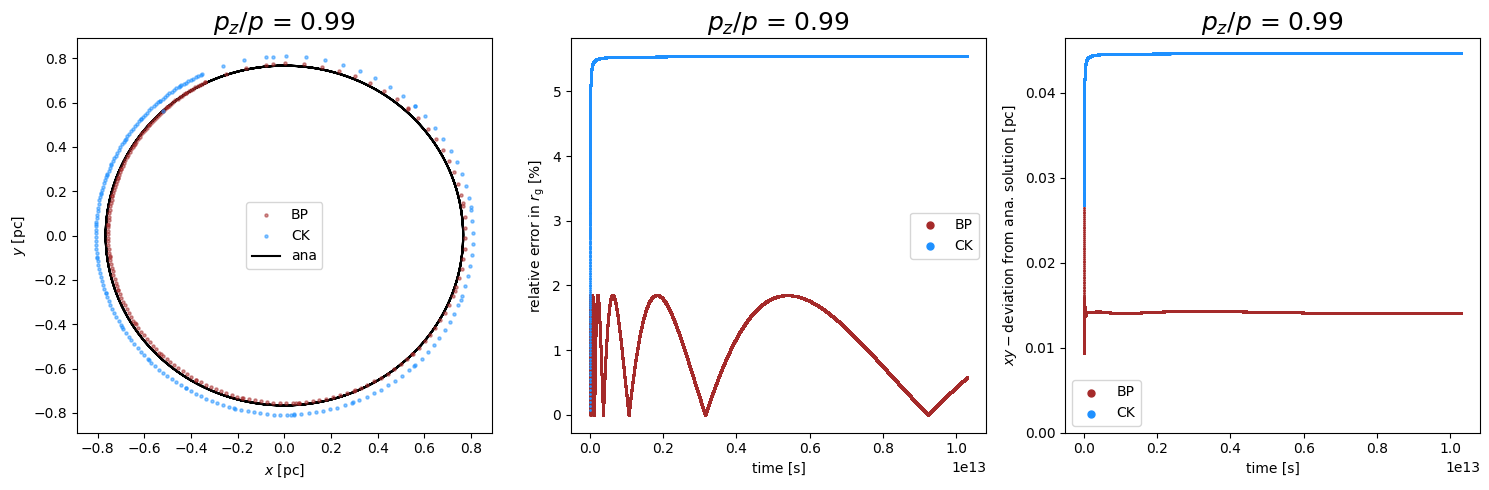

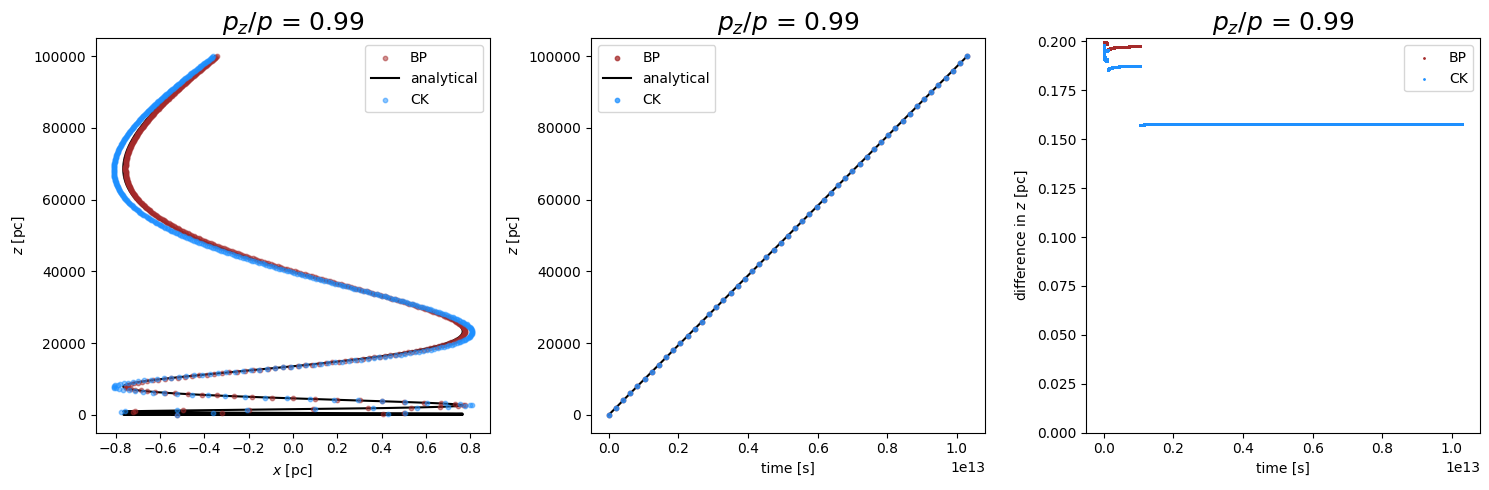

In [131]:
p_z = 0.99
#p_z, r_g_0 = run_simulation('CK', p_z)
#run_simulation('BP', p_z)
plot_figure_perp(max_trajectory, p_z, r_g_0, number_of_steps)
plot_figure_para(max_trajectory, p_z, r_g_0, number_of_steps)